# Copy of Qin's notebook

with just the gamma verification plots

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cftime
import cmocean as cm
from netCDF4 import Dataset
import os.path
import matplotlib.colors as colors

from matplotlib import gridspec

In [2]:
## folder where the isomip-plus github repo is located
baserepo = '/g/data/x77/cy8964/isomip-plus/'
## folder where you downloaded the zipped Google Drive data
basedrive = '/g/data/x77/cy8964/ISOMIP+Data-new/'

# load the data from the text files, which point to the right location of the file in the drive structure
Ocean0_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean0_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)


In [3]:
#12 model colours for 12 models, generated using https://colorbrewer2.org/#type=qualitative&scheme=Paired&n=12
modelcolours=['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']


In [4]:
# Constants

rho_fw = 1000 #kg/m3
L = 3.34e5 #J/kg
rho_sw = 1028 #kg/m3
Cw = 3974

GammaT={'COCO':2.5e-2,
'FVCOM':.2,
'MITgcm BAS':1.9e-2,
'MITgcm BAS CoupledV3':2.1e-2,
'MITgcm JPL':3.25e-2,
'MOM6':1.4e-1,
'MOM6 SIGMA ZSTAR':4.5e-2,
'MPAS-Ocean':1.94e-2,
'NEMO-CNRS':2.6e-2,
'NEMO-UKESM1is':4.5e-2,
'POP2x':1.146e-1,
'ROMSUTAS':5e-2}

Text(0.01, 0.99, 'b')

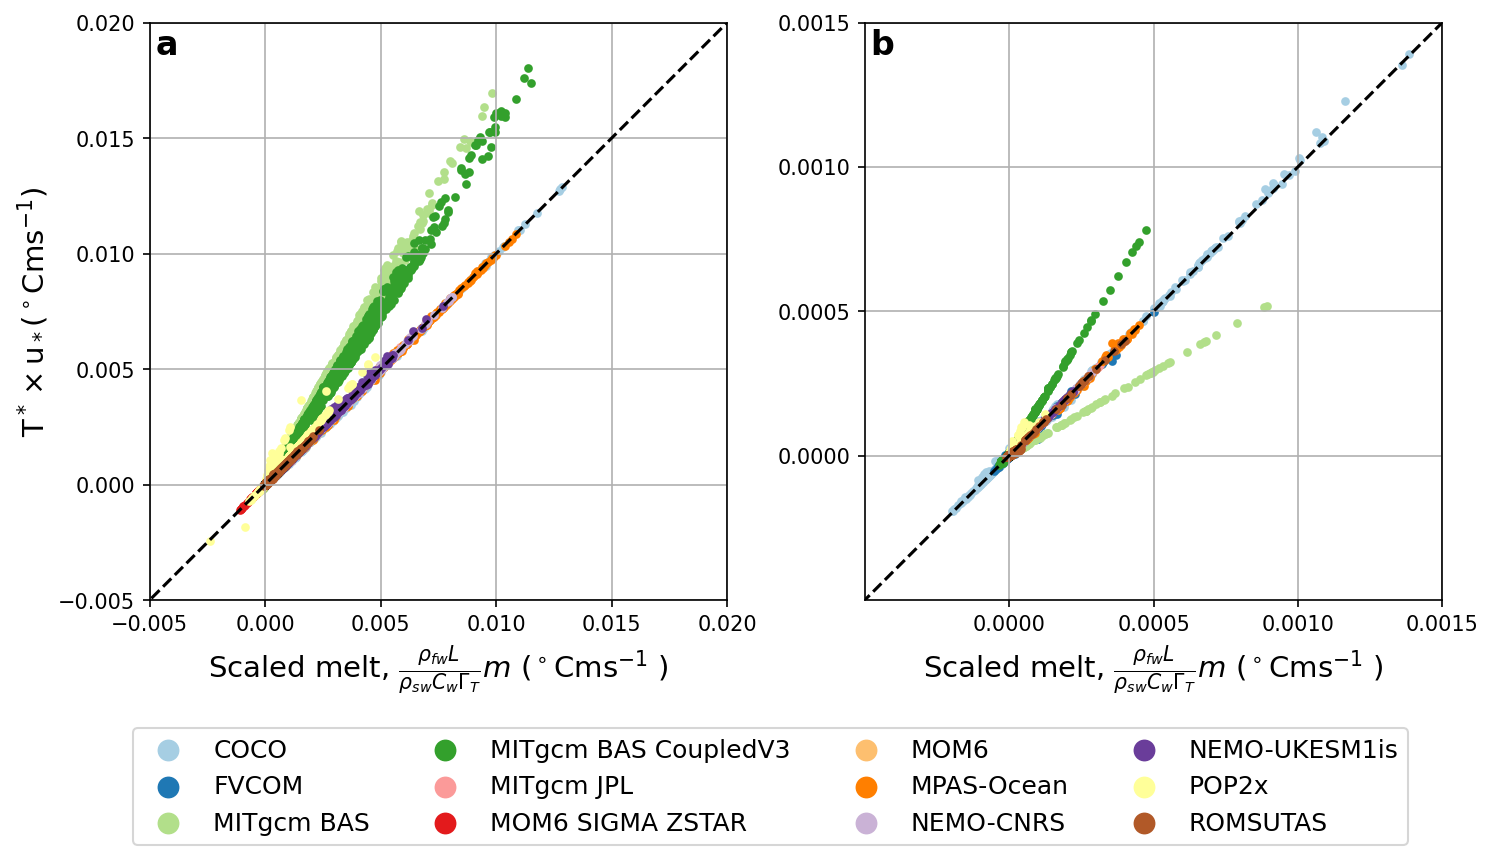

In [50]:
# scatter plot of melt rates aganst T^* and u_* for Ocean1_COM and Ocean2_COM

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.15, hspace=0.05)
fig = plt.figure(figsize=(11.5,5),facecolor='w',dpi = 150)


expt = Ocean1_COM
labels = []
for fileIndex in range(len(expt)):
    fileName = expt[fileIndex]
    baseName = os.path.basename(basedrive +fileName)
    modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
    labels.append(modelName)

length = len(expt)

# scatter plot of melt rates divided by constants aganst T^* times u_* for Ocean1_COM

ax=fig.add_subplot(gs[0])

for i in np.arange(length):

    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    time = len(data.nTime)
    melt = (data.meltRate).isel(nTime = np.arange(time-13,time)).mean('nTime')
    melt_av = (melt.where(melt<1e36))
    tstar = data.thermalDriving.isel(nTime = np.arange(time-13,time)).mean('nTime')
    tstar_av = (tstar.where(tstar<1e36)).where(melt!=0)
    ustar = data.frictionVelocity.isel(nTime = np.arange(time-13,time)).mean('nTime')
    ustar_av = (ustar.where(ustar<1e36)).where(melt!=0)
    melt_div_constants = melt_av*rho_fw*L/(rho_sw*GammaT[labels[i]]*Cw)
    ax.scatter(melt_div_constants, tstar_av*ustar_av,s=10,color=modelcolours[i])
    ax.scatter(melt_div_constants[-1], tstar_av[-1]*ustar_av[-1], s=10,label=labels[i],color=modelcolours[i])
    
ax.plot((-0.01,0.02),(-0.01,.02),'k--')
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),frameon=False,ncol=length/2,handletextpad=0.01)
ax.legend(fontsize=12, ncol = 4, loc = 'upper left', bbox_to_anchor = (-0.05,-0.2),markerscale=3.)

ax.set_xlim((-.005,0.02))
ax.set_ylim((-.005,0.02))
ax.set_aspect('equal')
ax.grid()
plt.xlabel(r'Scaled melt, $\frac{\rho_{fw}L}{\rho_{sw}C_w\Gamma_T}m$ ($^\circ$Cms$^{-1}$ )',fontsize=14)
plt.ylabel(r'$\mathrm{T^*\times u_* (^\circ C ms^{-1} )}$',fontsize=14)
plt.text(0.01,0.99,'a', fontsize = 16, transform=ax.transAxes, fontweight='bold', va='top')

### Ocean2

expt = Ocean2_COM
labels = []
for fileIndex in range(len(expt)):
    fileName = expt[fileIndex]
    baseName = os.path.basename(basedrive +fileName)
    modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
    labels.append(modelName)

length = len(expt)

# scatter plot of melt rates divided by constants aganst T^* times u_* for Ocean1_COM

ax=fig.add_subplot(gs[1])

for i in np.arange(length):

    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    time = len(data.nTime)
    melt = (data.meltRate).isel(nTime = np.arange(time-13,time)).mean('nTime')
    melt_av = (melt.where(melt<1e36))
    tstar = data.thermalDriving.isel(nTime = np.arange(time-13,time)).mean('nTime')
    tstar_av = (tstar.where(tstar<1e36)).where(melt!=0)
    ustar = data.frictionVelocity.isel(nTime = np.arange(time-13,time)).mean('nTime')
    ustar_av = (ustar.where(ustar<1e36)).where(melt!=0)
    melt_div_constants = melt_av*rho_fw*L/(rho_sw*GammaT[labels[i]]*Cw)
    ax.scatter(melt_div_constants, tstar_av*ustar_av,s=10,color=modelcolours[i])
    ax.scatter(melt_div_constants[-1], tstar_av[-1]*ustar_av[-1], s=10,label=labels[i],color=modelcolours[i])
    
ax.plot((-0.02,0.02),(-0.02,.02),'k--')
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),frameon=False,ncol=length/2,handletextpad=0.01)
#ax.legend(loc='lower right',frameon=False,handletextpad=0.01)

ax.set_xlim((-.0005,0.0015))
ax.set_ylim((-.0005,0.0015))
ax.set_yticks([0,0.0005,0.001,0.0015])
ax.set_xticks([0,0.0005,0.001,0.0015])
ax.set_aspect('equal')
ax.grid()
plt.xlabel(r'Scaled melt, $\frac{\rho_{fw}L}{\rho_{sw}C_w\Gamma_T}m$ ($^\circ$Cms$^{-1}$ )',fontsize=14)
#plt.ylabel(r'$\mathrm{T^*\times u_* (^\circ C  ms^{-1} )}$',fontsize=14)
plt.text(0.01,0.99,'b', fontsize = 16, transform=ax.transAxes, fontweight='bold', va='top')


In [10]:
#MOM6 SIGMAZSTAR

i = 5
data = xr.open_dataset(basedrive+expt[i], decode_times=False)

time = len(data.nTime)
melt = (data.meltRate).isel(nTime = np.arange(time-13,time)).mean('nTime')
melt_av = (melt.where(melt<1e36))
tstar = data.thermalDriving.isel(nTime = np.arange(time-13,time)).mean('nTime')
tstar_av = (tstar.where(tstar<1e36))
ustar = data.frictionVelocity.isel(nTime = np.arange(time-13,time)).mean('nTime')
ustar_av = (ustar.where(ustar<1e36))
melt_div_constants = melt_av*rho_fw*L/(rho_sw*GammaT[labels[i]]*Cw)


Text(0.5, 0.98, 'MOM6_SIGMAZSTAR')

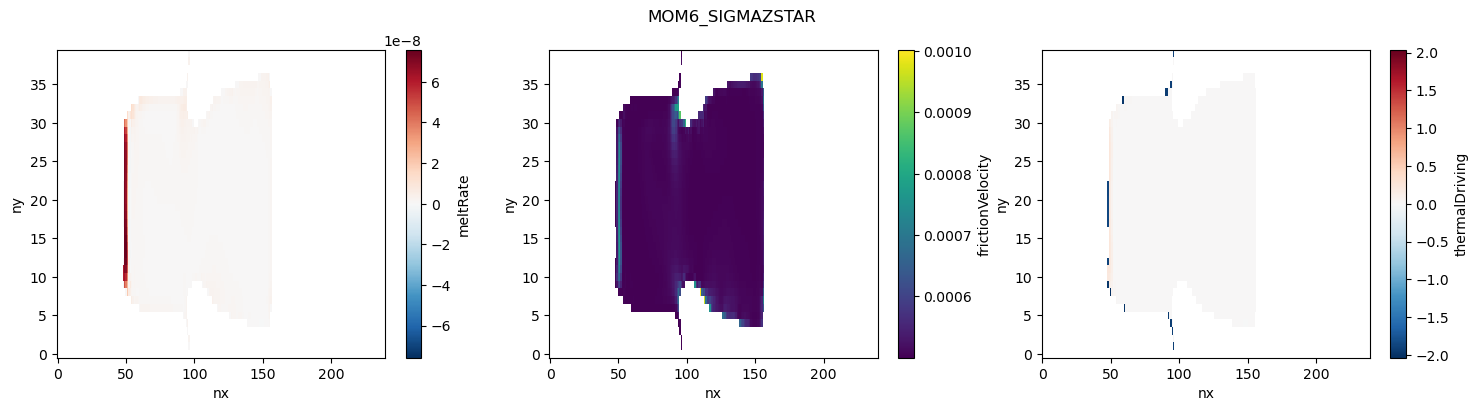

In [16]:
fig,axes = plt.subplots(ncols = 3, figsize = (18,4))
melt_av.plot(ax = axes[0])
(ustar_av).plot(ax = axes[1])
tstar_av.plot(ax = axes[2])

fig.suptitle('MOM6_SIGMAZSTAR')

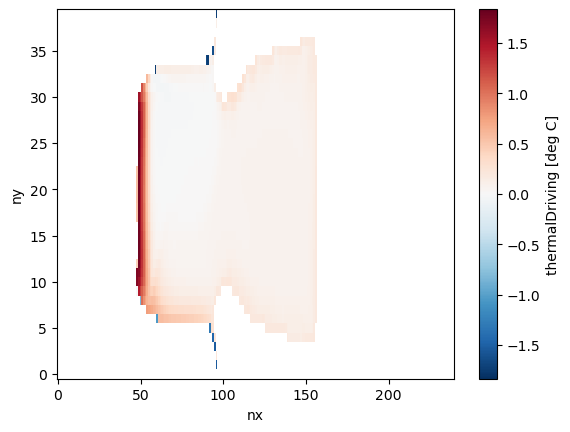

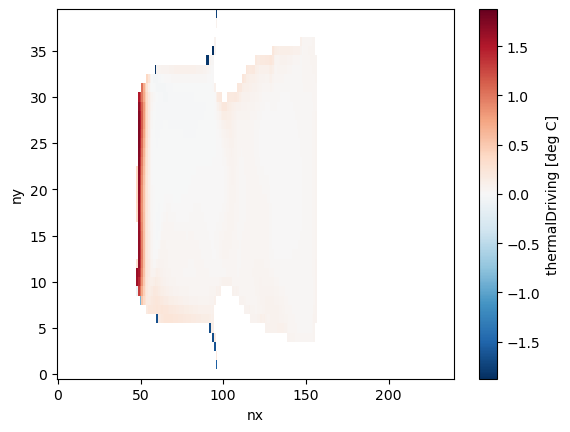

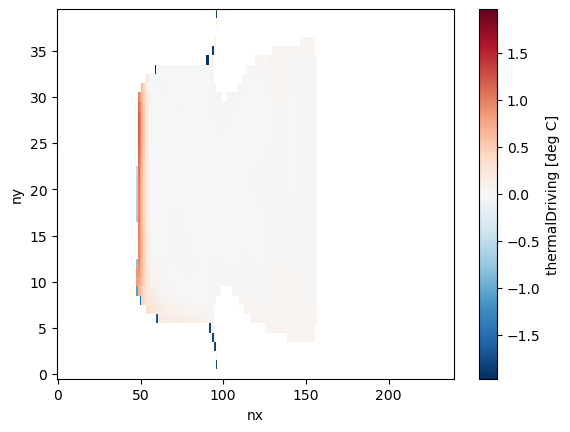

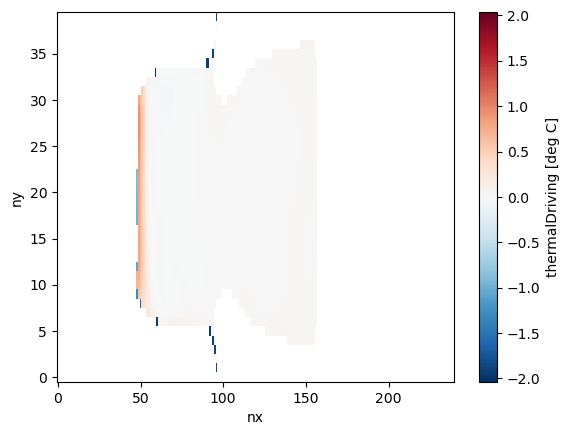

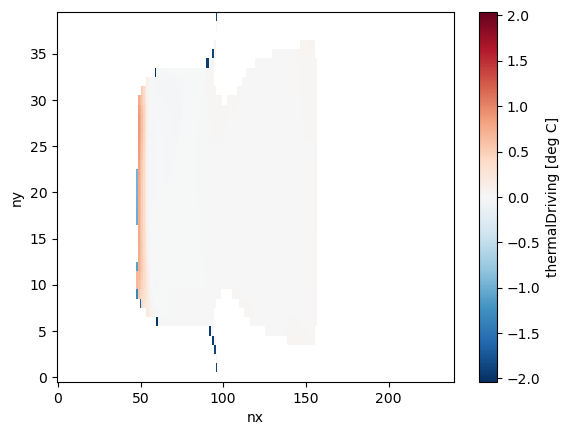

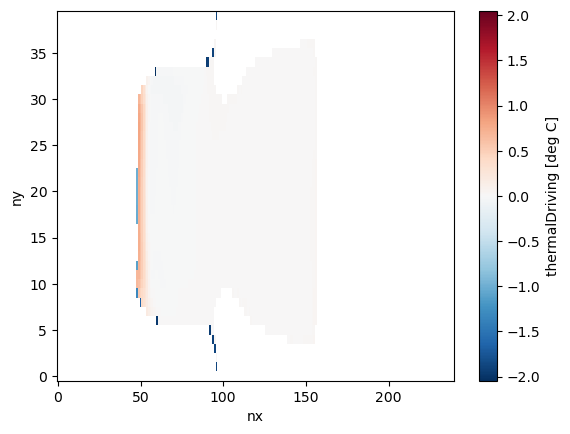

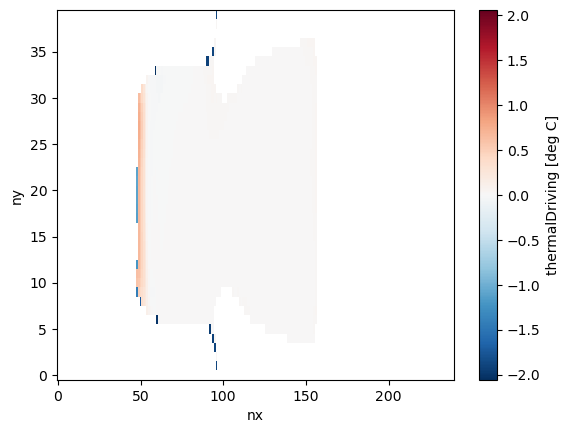

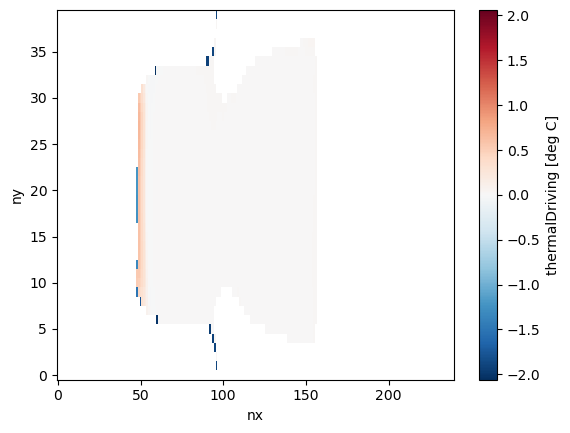

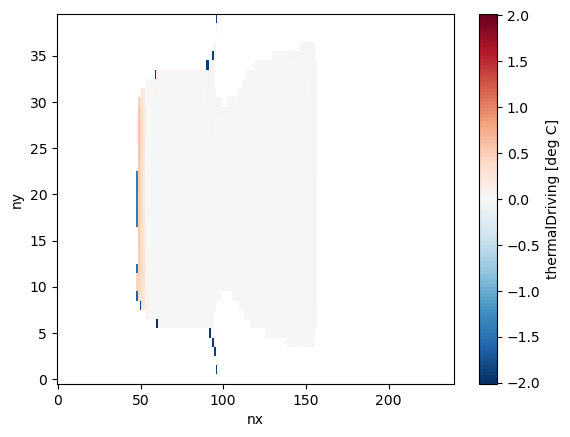

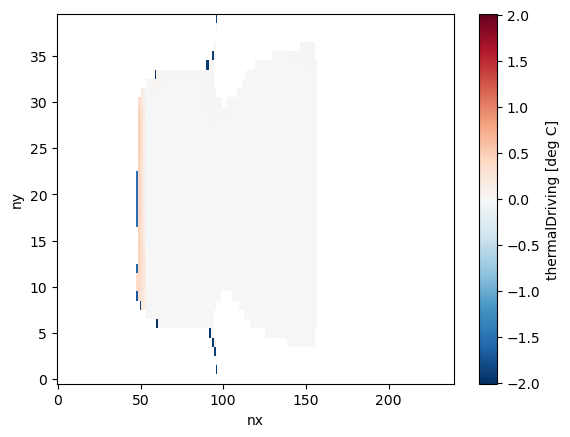

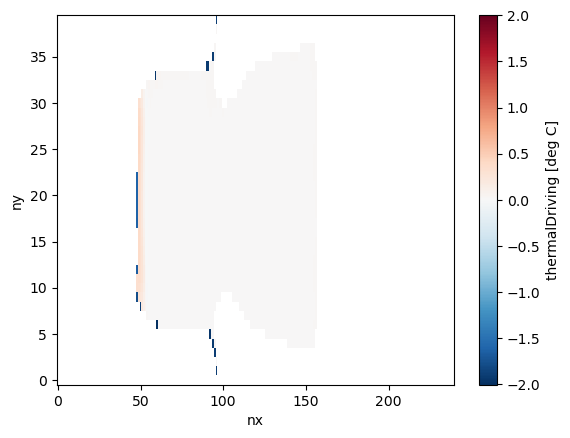

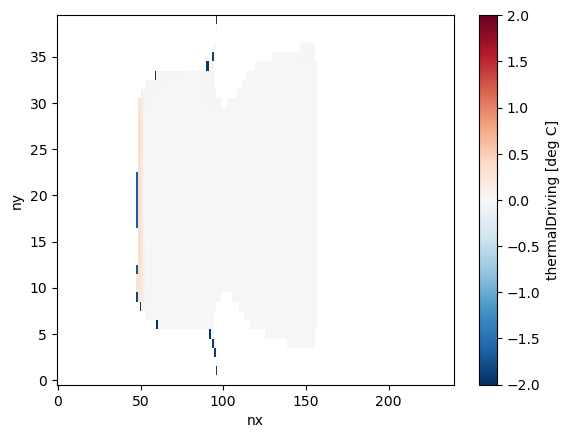

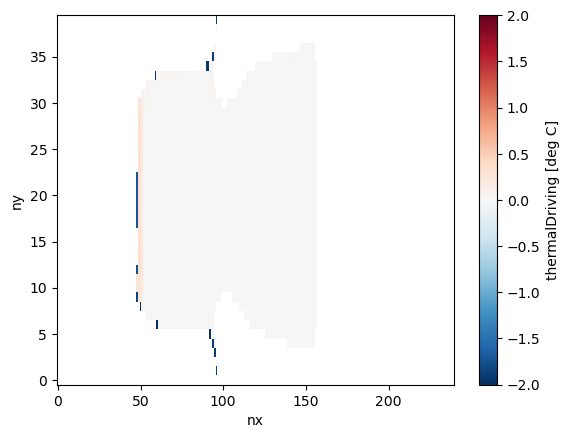

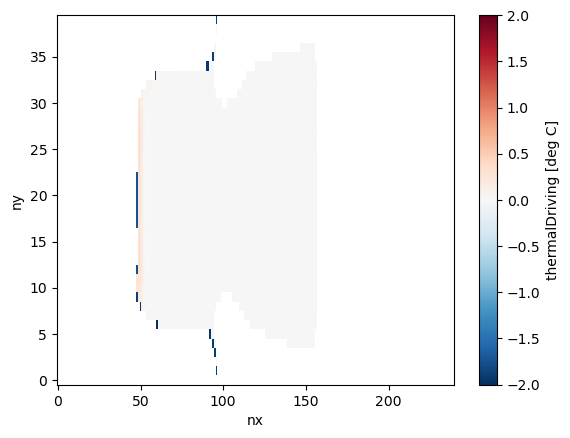

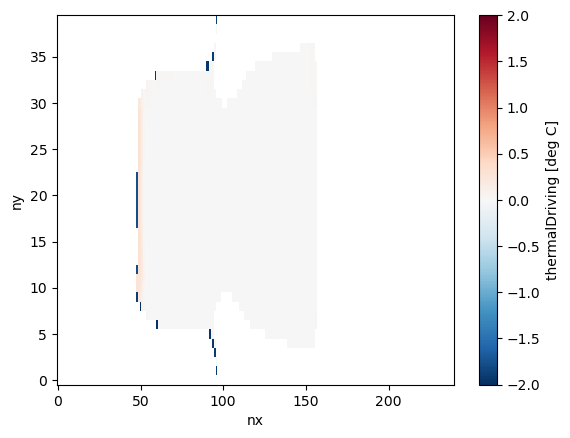

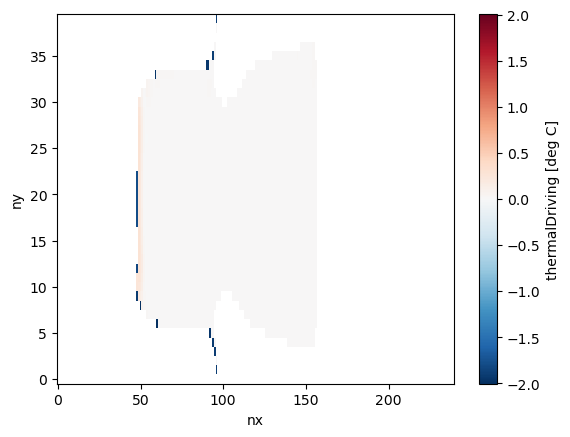

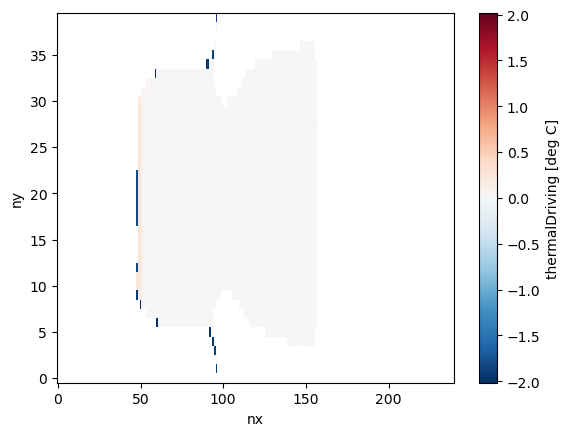

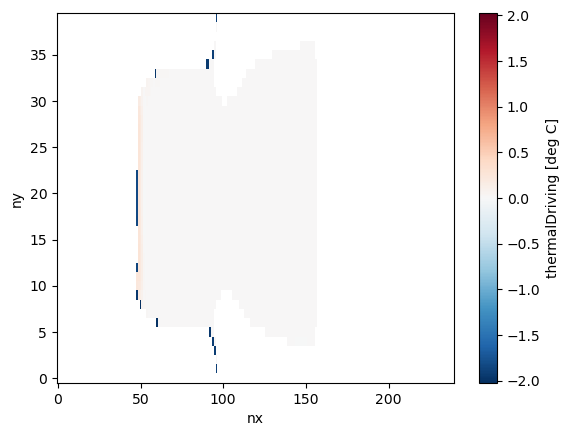

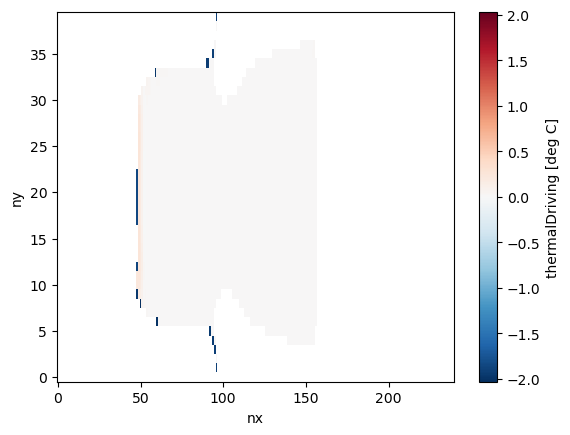

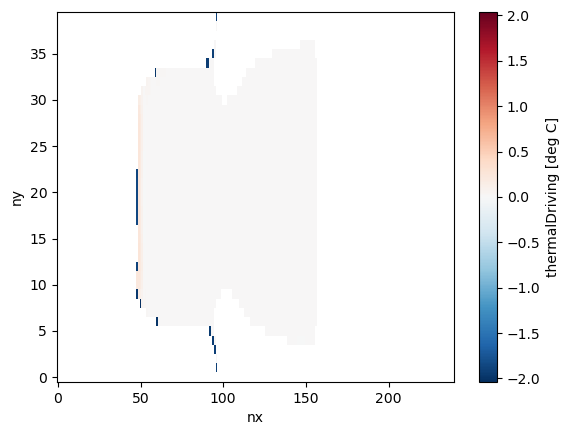

In [26]:
for i in data.thermalDriving.nTime.values[0::12]:
    data.thermalDriving.isel(nTime = i).where(data.thermalDriving.isel(nTime = i)<1e36).plot()
    plt.show()


In [27]:
data.thermalDriving.nTime.values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18